In [1]:
import numpy as np
import yahoo_api as yapi
import pandas as pd
import statistics as st
import timeit
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
def Weights_Computation(num_potfolio, min_asset, len_index):
    # Create a 2d null matrix
    null_matrix = np.zeros((num_potfolio, len_index))

    # Create a matrix of random values
    random_matrix = np.random.rand(num_potfolio * len(index))

    # Replace randomly x of the 0s in each row of the null array with values from the random matrix
    x = num_potfolio * avg_assets
    indices = np.random.choice(len(null_matrix.ravel()), x, replace=True)
    null_matrix.ravel()[indices] = random_matrix[indices]

    # Normalize each row of the matrix so that the sum of each row is equal to 1
    weight_matrix = null_matrix / np.sum(null_matrix, axis=1).reshape(-1,1)

    #create a mask to select the rows with 0s higher than min_asset
    mask = np.sum(weight_matrix != 0, axis=1) <= min_asset

    #apply the mask to the weight_matrix and get the result
    weight_matrix = weight_matrix[~mask]
    return(weight_matrix)

In [3]:
def Returns_computation(weight_matrix,asset_returns_matrix):
    # Multiply the weight matrix by the returns matrix to obtain portfolio's returns
    returns_matrix = np.dot(weight_matrix, asset_returns_matrix)

    # Computation of return of each portfolio
    return_matrix = (1 + np.sum(returns_matrix,axis=1)) ** (255/len(returns_matrix[0])) - 1
    return(returns_matrix, return_matrix)

In [4]:
def Metrics_computation(returns_matrix, return_matrix, benchmark_returns, benchmark_return):
    # Computation of the covariance of each portfolio with the benchmark
    x = returns_matrix
    y = benchmark_returns
    n = len(benchmark_returns)
    covariance_matrix = (np.sum(np.multiply(x,y), axis = 1) - n * np.mean(y) * np.mean(x, axis=1)) / (n-1)

    # Computation of the beta of each portfolio
    beta_matrix = covariance_matrix / st.variance(benchmark_returns)

    # Computation of the alpha of each portfolio
    alpha_matrix = return_matrix - (rf_rate + beta_matrix * (benchmark_return - rf_rate))
    
    # Computation of the expected return - CAPM - of each portfolio
    capm_matrix = rf_rate + beta_matrix * (benchmark_return - rf_rate)
    
    return(beta_matrix, alpha_matrix, capm_matrix)

In [32]:
def describe(matrix):
    decimal = 3
    count = len(matrix)
    mean = round(np.nanmean(matrix), decimal)
    min_ = round(min(matrix), decimal)
    max_ = round(max(matrix), decimal)
    std = round(np.nanstd(matrix), decimal)
    first, median, third = [round(x, 3) for x in np.nanpercentile(matrix, [25, 50, 75])]
    skewness = round(skew(matrix),decimal)
    kurt = round(kurtosis(matrix),decimal)
    df = pd.DataFrame(
        data = (count,mean,std,min_,first,median,third,max_,skewness,kurt),
        index = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis'),
        columns = ['description']
    )
    return(df)

In [6]:
%store -r DOW_30
# Set the list of asset's ticker of the study
index = DOW_30

# Set the benchmark of the study
index_ticker = '^DJI'

#Set the time period of the study
timeperiod = '1y'

# Set the annual risk free rate to alpha  
rf_rate = 0.025

# Set the number of trials of the monte carlo method
num_potfolio = 3000000

# Set the average number of assets by portfolio
avg_assets = 20

# Set the minimum number of assets by portfolio
min_asset = 5

In [7]:
start_time = timeit.default_timer()

# Acquisition of asset's history studied
assets_history = pd.DataFrame()
name_dict = {}
for ticker in index:
    history = yapi.ticker(ticker).history(timeperiod)['Close']
    name = yapi.ticker(ticker).info()['Name']
    assets_history[ticker] = history
    name_dict[name] = ticker
assets_history = assets_history.transpose()

# Acquisition of benchmark's history studied
benchmark_history = np.array(yapi.ticker(index_ticker).history(timeperiod)['Close'])

elapsed = timeit.default_timer() - start_time
print(f'Elapsed: {round(elapsed,4)} sec')

Elapsed: 49.9954 sec


In [8]:
# Computation of benchmark returns
benchmark_returns = np.diff(benchmark_history) / benchmark_history[:-1]
benchmark_return = (1 + np.sum(benchmark_returns)) ** (255/len(benchmark_returns)) - 1

In [9]:
start_time = timeit.default_timer()

asset_metrics = []
df_returns = pd.DataFrame()
df_asset_metrics = pd.DataFrame()

# Compute metrics -returns, beta, alpha- of each assets studied
for history, ticker in zip(assets_history.values, assets_history.index):
    asset_returns = np.diff(history) / history[:-1]
    asset_return = (1 + np.sum(asset_returns)) ** (255/len(asset_returns)) - 1
    asset_beta = np.cov(asset_returns, benchmark_returns)[0][1] / st.variance(benchmark_returns)
    asset_alpha = asset_return - (rf_rate + asset_beta * (benchmark_return - rf_rate))
    asset_capm = rf_rate + asset_beta * (benchmark_return - rf_rate)
    
    asset_metrics = [asset_return, asset_beta, asset_alpha,asset_capm]
    df_asset_metrics[ticker] = asset_metrics
    df_returns[ticker] = asset_returns

df_asset_metrics = df_asset_metrics.transpose()
df_asset_metrics.columns = ['Return', 'Beta', "Jensen_Alpha", 'CAPM_Return']
    
df_returns = df_returns.transpose()
df_returns.columns = assets_history.columns[1:]
assets_returns = df_returns.to_numpy()

elapsed = timeit.default_timer() - start_time
print(f'Elapsed: {round(elapsed,4)} sec')

Elapsed: 0.0816 sec


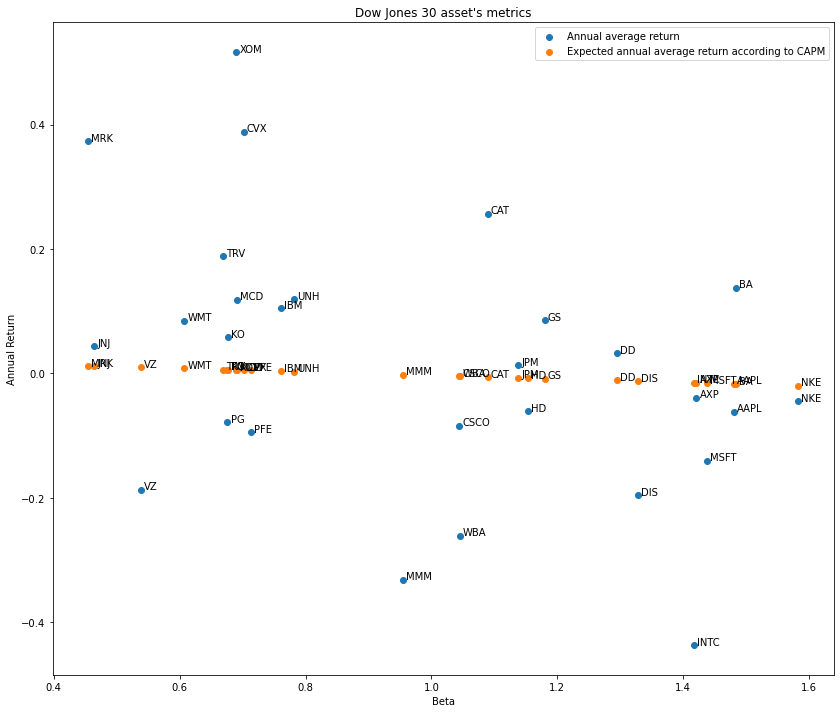

In [10]:
plt.figure(figsize=(14,12))
plt.scatter(df_asset_metrics.Beta, df_asset_metrics.Return, label='Annual average return') 
for asset, ticker in enumerate(df_asset_metrics.index):
    plt.annotate(ticker, (df_asset_metrics.Beta[asset]+0.005, df_asset_metrics.Return[asset]))
plt.title("Dow Jones 30 asset's metrics")
plt.scatter(df_asset_metrics.Beta, df_asset_metrics.CAPM_Return, label='Expected annual average return according to CAPM') 
for asset, ticker in enumerate(df_asset_metrics.index):
    plt.annotate(ticker, (df_asset_metrics.Beta[asset]+0.005, df_asset_metrics.CAPM_Return[asset]))
plt.title("Dow Jones 30 asset's metrics")
plt.xlabel('Beta') 
plt.ylabel('Annual Return') 
plt.legend() 
plt.show()

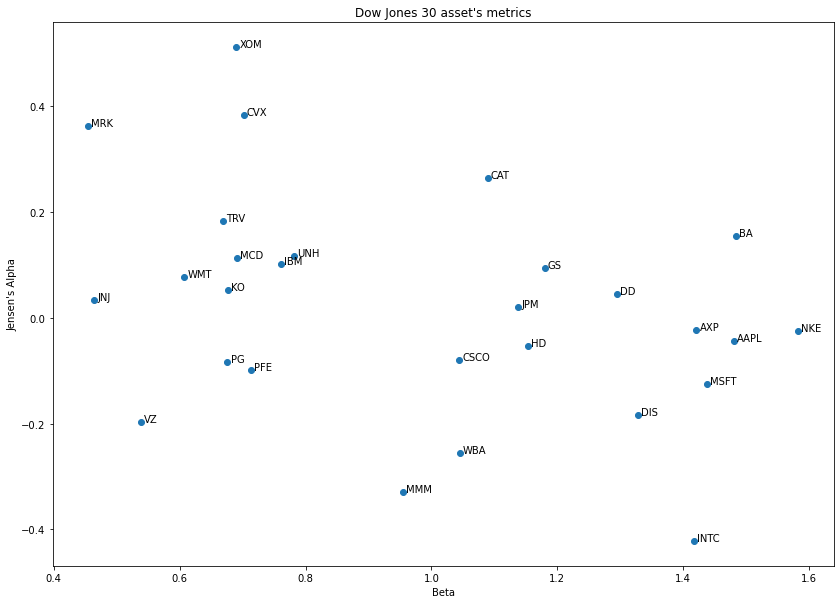

In [11]:
plt.figure(figsize=(14,10))
plt.scatter(df_asset_metrics.Beta, df_asset_metrics.Jensen_Alpha)
for asset, ticker in enumerate(df_asset_metrics.index):
    plt.annotate(ticker, (df_asset_metrics.Beta[asset]+0.005, df_asset_metrics.Jensen_Alpha[asset]))
plt.title("Dow Jones 30 asset's metrics")
plt.xlabel('Beta')
plt.ylabel("Jensen's Alpha")
plt.show()

In [12]:
start_time = timeit.default_timer()

# Computation of Asset's weights of potrfolios
weight_matrix = Weights_Computation(num_potfolio, min_asset, len(index))

# Computation of portfolio's returns
returns_matrix, return_matrix = Returns_computation(weight_matrix, assets_returns)

# Computation of protfolio's metrics
beta_matrix, alpha_matrix, capm_matrix = Metrics_computation(returns_matrix, return_matrix, benchmark_returns, benchmark_return)

elapsed = timeit.default_timer() - start_time
print(f'Elapsed: {round(elapsed,4)} sec')

Elapsed: 200.614 sec


In [36]:
describe(return_matrix)

,description
count,2999087.000
mean,0.018
std,0.053
min,-0.321
25%,-0.017
50%,0.017
75%,0.053
max,0.355
skewness,0.054
kurtosis,0.191


In [33]:
describe(beta_matrix)

,description
count,2999087.000
mean,0.981
std,0.087
min,0.519
25%,0.923
50%,0.981
75%,1.039
max,1.449
skewness,0.041
kurtosis,0.152


In [35]:
describe(alpha_matrix)

,description
count,2999087.000
mean,0.020
std,0.052
min,-0.309
25%,-0.014
50%,0.020
75%,0.055
max,0.351
skewness,0.051
kurtosis,0.190


In [64]:
describe(alpha_matrix)['description']

count       2999087.000
mean              0.020
std               0.052
min              -0.309
25%              -0.014
50%               0.020
75%               0.055
max               0.351
skewness          0.051
kurtosis          0.190
Name: description, dtype: float64

In [67]:
pd.DataFrame(data = (describe(return_matrix)['description'],describe(beta_matrix)['description'],describe(alpha_matrix)['description'],describe(capm_matrix)['description']),
             index = ['Average Return', 'Beta', 'Alpha', 'CAPM Return']
            ).transpose()


,Average Return,Beta,Alpha,CAPM Return
count,2999087.000,2999087.000,2999087.000,2999087.000
mean,0.018,0.981,0.020,-0.003
std,0.053,0.087,0.052,0.002
min,-0.321,0.519,-0.309,-0.016
25%,-0.017,0.923,-0.014,-0.004
50%,0.017,0.981,0.020,-0.003
75%,0.053,1.039,0.055,-0.001
max,0.355,1.449,0.351,0.010
skewness,0.054,0.041,0.051,-0.041
kurtosis,0.191,0.152,0.190,0.152


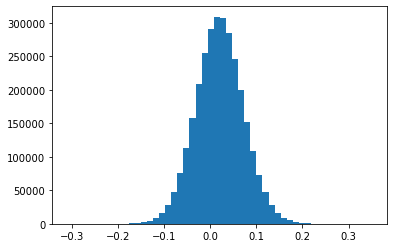

In [42]:
plt.hist(alpha_matrix, bins=50)
plt.show()

'Best' portfolio founded over 2999087 portfolios studied
Alpha: 0.351
Beta: 0.732


<function matplotlib.pyplot.show(close=None, block=None)>

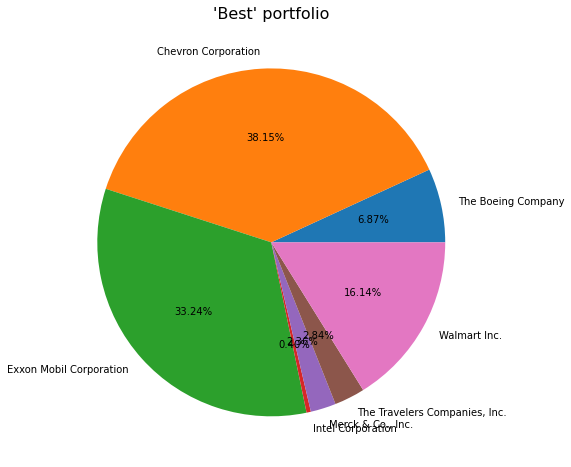

In [44]:
# Look up for the best portfolio
max_alpha = max(alpha_matrix)
id_best_alpha = list(np.where(alpha_matrix == max_alpha)[0])[0]
weight_best_portfolio = weight_matrix[id_best_alpha]
best_portfolio = {}

# Compute the DataFrame of best portfolio
for weight, ticker in zip(weight_best_portfolio, index):
    best_portfolio[ticker] = weight
best_portfolio = {key: round(value*100,3) for key, value in best_portfolio.items() if value != 0}

name_asset_best_portfolio = [keys for keys, values in name_dict.items() if values in best_portfolio.keys()]

df_best_portfolio = pd.DataFrame(data = (best_portfolio.items()),
                              index = (name_asset_best_portfolio),
                              columns = ['Ticker','Weight (%)'])
alpha = max_alpha
beta = beta_matrix[id_best_alpha]

# Print results
print(
    f"""'Best' portfolio founded over {len(weight_matrix)} portfolios studied
Alpha: {round(alpha,3)}
Beta: {round(beta,3)}"""
)

# Plot the best portfolio founded
fig = plt.figure(figsize=(8,8))
fig = plt.title("'Best' portfolio", fontsize=16)
plt.pie(df_best_portfolio['Weight (%)'], labels=df_best_portfolio.index, autopct='%1.2f%%')
plt.show

'Less' risk portfolio founded over 2999087 portfolios studied
Alpha: 0.109
Beta: 0.519


<function matplotlib.pyplot.show(close=None, block=None)>

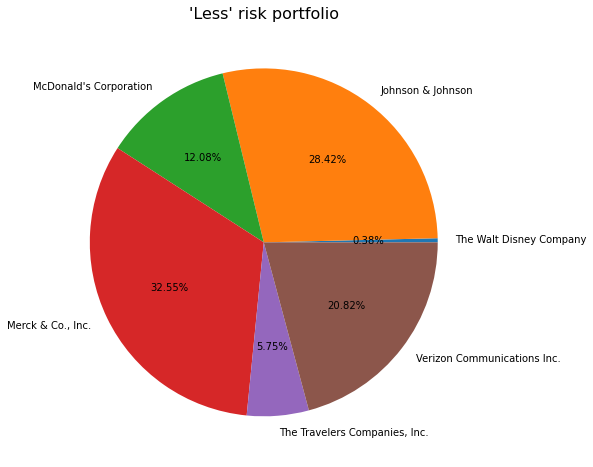

In [48]:
# Look up for the best portfolio
max_alpha = min(beta_matrix)
id_best_alpha = list(np.where(beta_matrix == max_alpha)[0])[0]
weight_best_portfolio = weight_matrix[id_best_alpha]
best_portfolio = {}

# Compute the DataFrame of best portfolio
for weight, ticker in zip(weight_best_portfolio, index):
    best_portfolio[ticker] = weight
best_portfolio = {key: round(value*100,3) for key, value in best_portfolio.items() if value != 0}

name_asset_best_portfolio = [keys for keys, values in name_dict.items() if values in best_portfolio.keys()]

df_best_portfolio = pd.DataFrame(data = (best_portfolio.items()),
                              index = (name_asset_best_portfolio),
                              columns = ['Ticker','Weight (%)'])
alpha = alpha_matrix[id_best_alpha]
beta = beta_matrix[id_best_alpha]

# Print results
print(
    f"""'Less' risk portfolio founded over {len(weight_matrix)} portfolios studied
Alpha: {round(alpha,3)}
Beta: {round(beta,3)}"""
)

# Plot the best portfolio founded
fig = plt.figure(figsize=(8,8))
fig = plt.title("'Less' risk portfolio", fontsize=16)
plt.pie(df_best_portfolio['Weight (%)'], labels=df_best_portfolio.index, autopct='%1.2f%%')
plt.show